# Fisher Analysis for an SDM Universe

In this notebook we run a modified version of `CLASS` that incoporates scattering dark matter (SDM), and `21cmFirstCLASS`. Together they produce CMB (angular) and 21-cm power spectra for an SDM Universe, which we use to perform a Fisher analysis.

## The Model

The SDM models add several new parameters into the $\Lambda$CDM$ model, namely the fraction of CDM that scatters $f_\chi$, the SDM particle mass $m_\chi$, and the cross section $\sigma =\sigma_n (v/c)^n$, where $n$ is a power-law index. For simplicity, we have assumed fixed values of $f_\chi =1$ and $n=-4$.

To perform a Fisher analysis, we first need to specify the fiducial values of our parameters (which we vary). The standard LCDM parameters are taken from the 2nd to last column of Table 2 of the [Planck 2018 paper](https://arxiv.org/abs/1807.06209). The SDM parameters are taken from the [21cmFirstCLASS paper](https://arxiv.org/abs/2309.03942).

In `CLASS`, the above prescription leads to `omega_cdm = 0` but `omega_dmeff = 0.11933`. There are several other nuisance parameters that we do not focus on, but we still set them according to `21cmFirstCLASS` to facilitate later sections where we add the 21-cm power spectrum as another observable.

---

## `CLASS` for CMB Data

In [174]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

params = {
    # ---LCDM parameters---
    'A_s': 2.1e-9,
    'n_s': 0.9665,
    'h': 0.6736,
    'tau_reio': 0.0544,
    'omega_b': 0.02237,
    'omega_cdm': 0., # Instead of using this, we will use omega_dmeff
    # ---SDM parameters---
    'omega_dmeff': 0.1200, # This is considered to be part of the LCDM parameters below
    'm_dmeff': 1e-3, # GeV
    'N_dmeff': 1,
    # 'sigma_dmeff': pow(10.,-42.),
    'log10sigma_dmeff': -42,
    'npow_dmeff': -4,
    'dmeff_target': 'baryon',
    'Vrel_dmeff': 30.,
    # ---Nuisance parameters to match 21cmFirstCLASS---
    'T_cmb': 2.728,
    'm_ncdm': '0.06', # eV
    'N_ncdm': 1,
    'N_ur': 2.0308,
    # 'z_pk': 1087.,
    # 'P_k_max_1/Mpc': 4000.,
    # ---Output parameters---
    'output': 'tCl pCl lCl',
    # 'output': 'tCl, pCl, lCl, mTk ,vTk',
    'lensing': 'yes',
    'l_max_scalars': 3000,
}

params_LCDM = ['A_s', 'n_s', 'h', 'tau_reio', 'omega_b', 'omega_dmeff']
params_SDM = [
    'm_dmeff', 
    # 'sigma_dmeff',
    'log10sigma_dmeff'
]
params_to_vary = params_LCDM + params_SDM

cosmo = Class()
cosmo.set(params)
cosmo.compute()

### The CMB Fisher Matrix

The covaraince matrix for the CMB data is given by
$$
    \Sigma_\text{CMB}
    =\text{diag} \left( \frac{2}{2l+1} C_l^2 \right) .
$$
Then we compute the Fisher matrix via
$$
    F_{ij}
    =\mathbf{C}_{,p_i}^T \Sigma_\text{CMB}^{-1} \mathbf{C}_{,p_j} .
$$

In [175]:
# Compute the covariance matrix inverse
ClTT = cosmo.lensed_cl()['tt'][2:] # shape (2999,)
ClEE = cosmo.lensed_cl()['ee'][2:]
ClTE = cosmo.lensed_cl()['te'][2:]
ll = cosmo.lensed_cl()['ell'][2:]

Error = 2/(2*ll + 1)*ClTT**2
C = np.diag(1/Error) # This is the inverse!



# Compute the partial derivatives (central difference method)
# dr refers to step choosen wrt a certain ratio of the parameter, df refers to the step choosen with a fixed value
h = 1e-3
def dr(p):
    cosmo.set({p: params[p]*(1 + h)})
    cosmo.compute()
    cl_r = cosmo.lensed_cl()['tt'][2:]
    
    cosmo.set({p: params[p]*(1 - h)})
    cosmo.compute()
    cl_l = cosmo.lensed_cl()['tt'][2:]
    
    return (cl_r - cl_l)/(2*h*params[p])

dCldp = np.array([dr(p) for p in params_to_vary])



# Combine the above results to compute the Fisher matrix
dCldp_T = np.transpose(dCldp)
F = dCldp@C@dCldp_T

In [182]:
# Compute the covariance matrix inverse for combined modes

h=0.001
def dr(p, mode):
    cosmo.set({p: params[p]*(1 + h)})
    cosmo.compute()
    cl_r = cosmo.lensed_cl()[mode][2:]
    
    cosmo.set({p: params[p]*(1 - h)})
    cosmo.compute()
    cl_l = cosmo.lensed_cl()[mode][2:]
    
    return (cl_r - cl_l)/(2*h*params[p])

ll = cosmo.lensed_cl()['ell'][2:]

def F(mode):
    C = np.diag(1/(2/(2*ll + 1)*(cosmo.lensed_cl()[mode][2:])**2))
    dCldp = np.array([dr(p, mode) for p in params_to_vary])
    dCldp_T = np.transpose(dCldp)
    return dCldp@C@dCldp_T

f = 0.4 # sky fraction
Cl = np.array([[cosmo.lensed_cl()['tt'][2:], cosmo.lensed_cl()['te'][2:]], [cosmo.lensed_cl()['te'][2:], cosmo.lensed_cl()['ee'][2:]]])
dClTTdp = np.array([dr(p, 'tt') for p in params_to_vary])
dClTEdp = np.array([dr(p, 'te') for p in params_to_vary])
dClEEdp = np.array([dr(p, 'ee') for p in params_to_vary])

F_CMB = np.zeros((len(params_to_vary), len(params_to_vary)))
for i in range(len(params_to_vary)):
    for j in range(len(params_to_vary)):
        for l in range(params['l_max_scalars'] - 2):
            dclalpha = np.array([[dClTTdp[i][l], dClTEdp[i][l]], [dClTEdp[i][l], dClEEdp[i][l]]])
            dclbeta = np.array([[dClTTdp[j][l], dClTEdp[j][l]], [dClTEdp[j][l], dClEEdp[j][l]]])
            trace = np.trace(np.linalg.inv(Cl[:, :, l])@dclalpha@np.linalg.inv(Cl[:, :, l])@dclbeta)
            F_CMB[i][j] += f*(2*l+1)/2*trace

### Fisher Ellipses

In [176]:
# Marginalize over parameters
def marg2(F, i, j):
    F_inv = np.linalg.inv(F)
    G_inv = F_inv[[i, j], :][:, [i, j]] # Pick out the sub-matrix
    G = np.linalg.inv(G_inv)
    return G

def marg1(F, i):
    F_inv = np.linalg.inv(F)
    G_inv = F_inv[i, i]
    G = 1/G_inv
    return G

# Plot ellipses
def plot_quadratic_curve(ax, color, x0, y0, sx, sy, G, f):
    """
    Plots a curve defined by the quadratic equation:
    G[0, 0](x - x0)^2 + 2G[0, 1](x - x0)(y - y0) + G[1, 1](y - y0)^2 = 1/f.
    """
    
    # Create a grid of x, y points
    x = np.linspace(x0 - sx, x0 + sx, 400)
    y = np.linspace(y0 - sy, y0 + sy, 400)
    x, y = np.meshgrid(x, y)

    # Compute the values of the quadratic form
    Z = G[0, 0]*(x - x0)**2 + 2*G[0, 1]*(x - x0)*(y - y0) + G[1, 1]*(y - y0)**2 - 1/f
    
    # Plot the curve
    ax.contourf(x, y, Z, levels=[-1/f, 0], colors=color, alpha=0.5)
    ax.set_xlim([x0 - sx, x0 + sx])
    ax.set_ylim([y0 - sy, y0 + sy])
    ax.axvline(x0)
    ax.axhline(y0)
    ax.grid(True)

### Plots

Below we plot the SDM parameters against all parameters, and then the LCDM parameters agsinst themselves. First we do this for only the $C_l^\text{TT}$.

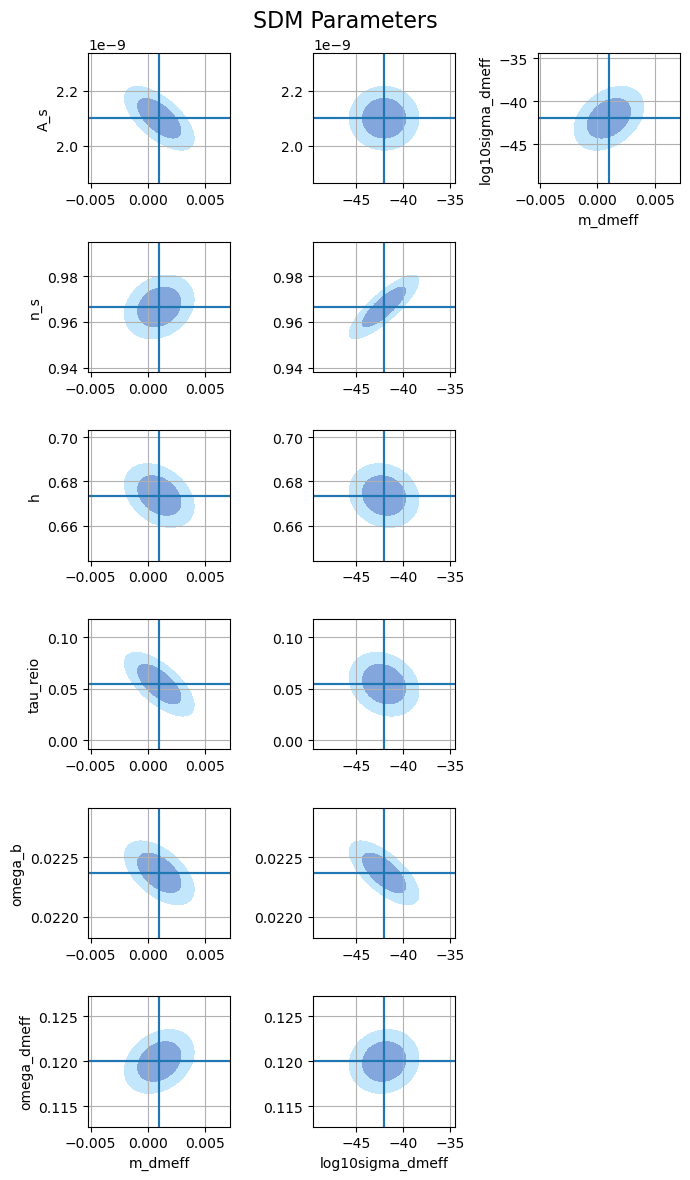

In [177]:
fig, axs = plt.subplots(6, 3, figsize=[7, 12])
fig.suptitle('SDM Parameters', fontsize=16)

for j, param_1 in enumerate(params_SDM):
    for i, param_2 in enumerate(params_LCDM):
#         axs[i, j].set_title(param_1 + ', ' + param_2)
        # Compute G
        G = marg2(F, j + 6, i)
        
        for f in [0.434, 0.167]:

            # Distinguish different confidence levels with colors
            if f == 0.434:
                color = 'navy'
            else:
                color = 'lightskyblue'

            # Plot the Fisher ellipse
            plot_quadratic_curve(
                ax=axs[i, j], color=color,
                x0=params[param_1], y0=params[param_2],
                sx=5/np.sqrt(marg1(F, j + 6)), sy=5/np.sqrt(marg1(F, i)),
                G=G, f=f
            )

        # Add labels
        if i == 5:
            axs[i, j].set_xlabel(param_1)
        if j == 0:
            axs[i, j].set_ylabel(param_2)
            
# Plot an extra one on the side
for i, param_2 in enumerate(params_LCDM):
    if i != 0:
        axs[i, 2].remove()
    else:
        # Compute G
        G = marg2(F, 6, 7)
        
        for f in [0.434, 0.167]:
            # Distiinguish different confidence levels with colors
            if f == 0.434:
                color = 'navy'
            else:
                color = 'lightskyblue'

            # Plot the Fisher ellipse
            plot_quadratic_curve(
                ax=axs[0, 2], color=color,
                x0=params['m_dmeff'], y0=params['log10sigma_dmeff'],
                sx=5/np.sqrt(marg1(F, 6)), sy=5/np.sqrt(marg1(F, 7)),
                G=G, f=f
            )
        
        axs[0, 2].set_xlabel(params_SDM[0])
        axs[0, 2].set_ylabel(params_SDM[1])
            
fig.tight_layout()

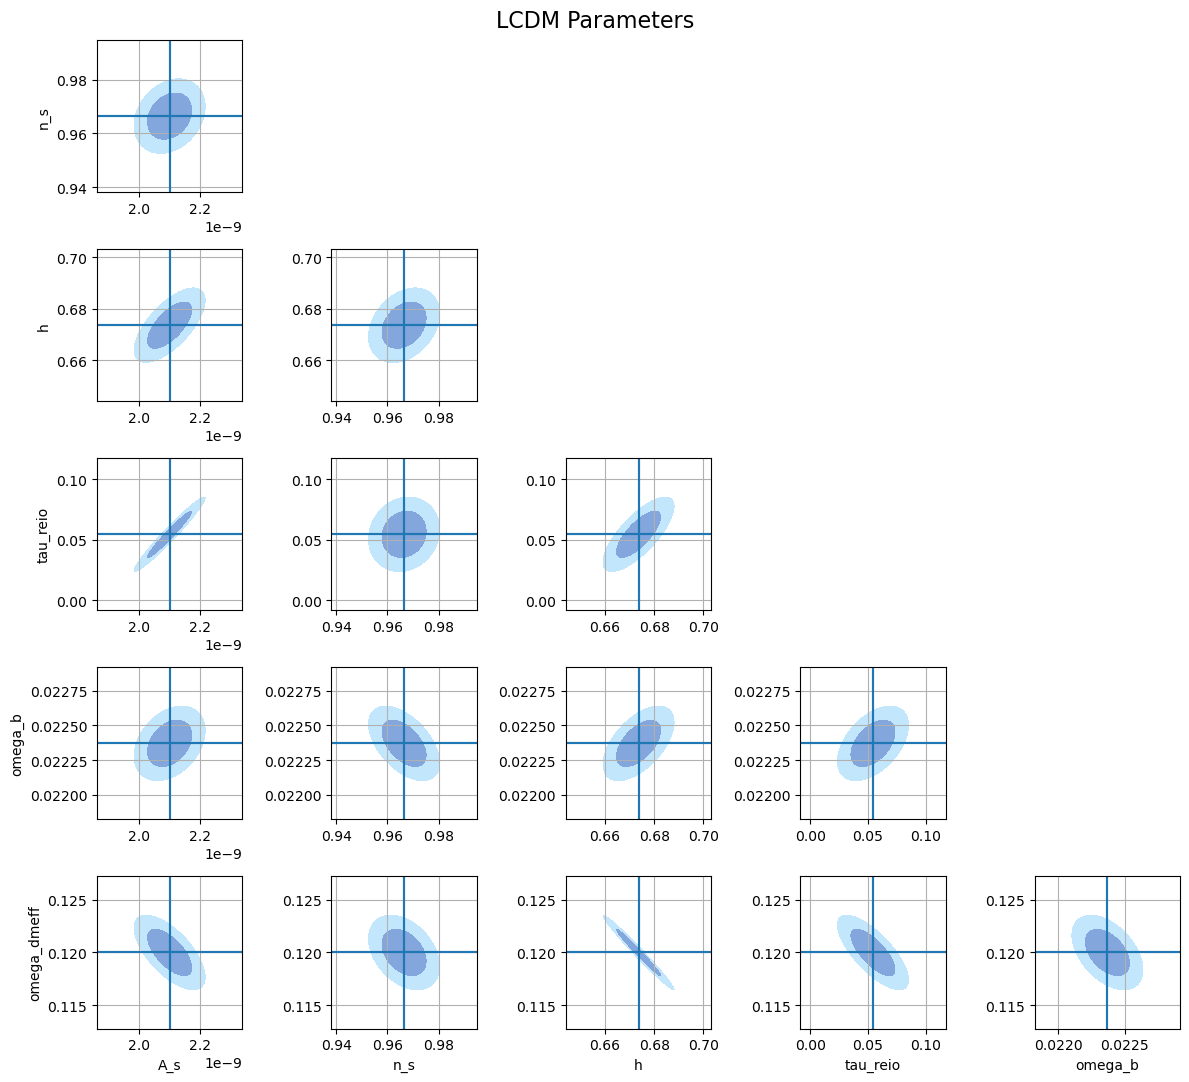

In [179]:
fig, axs = plt.subplots(5, 5, figsize=(12, 11))
fig.suptitle('LCDM Parameters', fontsize=16)

for j, param_1 in enumerate(params_LCDM[:-1]):
    for i, param_2 in enumerate(params_LCDM[1:]):
        if i < j:
            axs[i, j].remove()
        else:
#             axs[i, j].set_title(param_1 + ', ' + param_2)
            for f in [0.434, 0.167]:
                # Compute G
                G = marg2(F, j, i + 1)
                
                # Distiinguish different confidence levels with colors
                if f == 0.434:
                    color = 'navy'
                else:
                    color = 'lightskyblue'
                
                # Plot the Fisher ellipse
                plot_quadratic_curve(
                    ax=axs[i, j], color=color,
                    x0=params[param_1], y0=params[param_2],
                    sx=5/np.sqrt(marg1(F, j)), sy=5/np.sqrt(marg1(F, i + 1)),
                    G=G, f=f)
            
            # Add labels
            if i == 4:
                axs[i, j].set_xlabel(param_1)
            if j == 0:
                axs[i, j].set_ylabel(param_2)

fig.tight_layout()

Now we do the same thing for combined data used in CMB-S4.

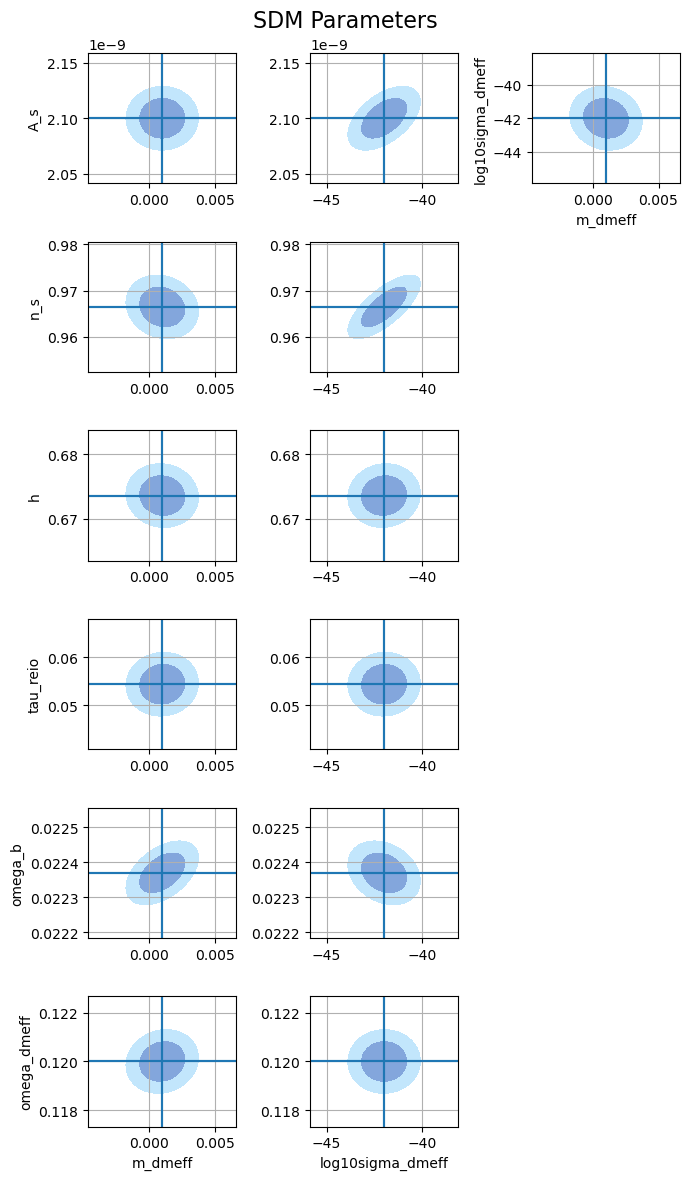

In [185]:
fig, axs = plt.subplots(6, 3, figsize=[7, 12])
fig.suptitle('SDM Parameters', fontsize=16)

for j, param_1 in enumerate(params_SDM):
    for i, param_2 in enumerate(params_LCDM):
#         axs[i, j].set_title(param_1 + ', ' + param_2)
        # Compute G
        G = marg2(F_CMB, j + 6, i)
        
        for f in [0.434, 0.167]:

            # Distinguish different confidence levels with colors
            if f == 0.434:
                color = 'navy'
            else:
                color = 'lightskyblue'

            # Plot the Fisher ellipse
            plot_quadratic_curve(
                ax=axs[i, j], color=color,
                x0=params[param_1], y0=params[param_2],
                sx=5/np.sqrt(marg1(F_CMB, j + 6)), sy=5/np.sqrt(marg1(F_CMB, i)),
                G=G, f=f
            )

        # Add labels
        if i == 5:
            axs[i, j].set_xlabel(param_1)
        if j == 0:
            axs[i, j].set_ylabel(param_2)
            
# Plot an extra one on the side
for i, param_2 in enumerate(params_LCDM):
    if i != 0:
        axs[i, 2].remove()
    else:
        # Compute G
        G = marg2(F_CMB, 6, 7)
        
        for f in [0.434, 0.167]:
            # Distiinguish different confidence levels with colors
            if f == 0.434:
                color = 'navy'
            else:
                color = 'lightskyblue'

            # Plot the Fisher ellipse
            plot_quadratic_curve(
                ax=axs[0, 2], color=color,
                x0=params['m_dmeff'], y0=params['log10sigma_dmeff'],
                sx=5/np.sqrt(marg1(F_CMB, 6)), sy=5/np.sqrt(marg1(F_CMB, 7)),
                G=G, f=f
            )
        
        axs[0, 2].set_xlabel(params_SDM[0])
        axs[0, 2].set_ylabel(params_SDM[1])
            
fig.tight_layout()

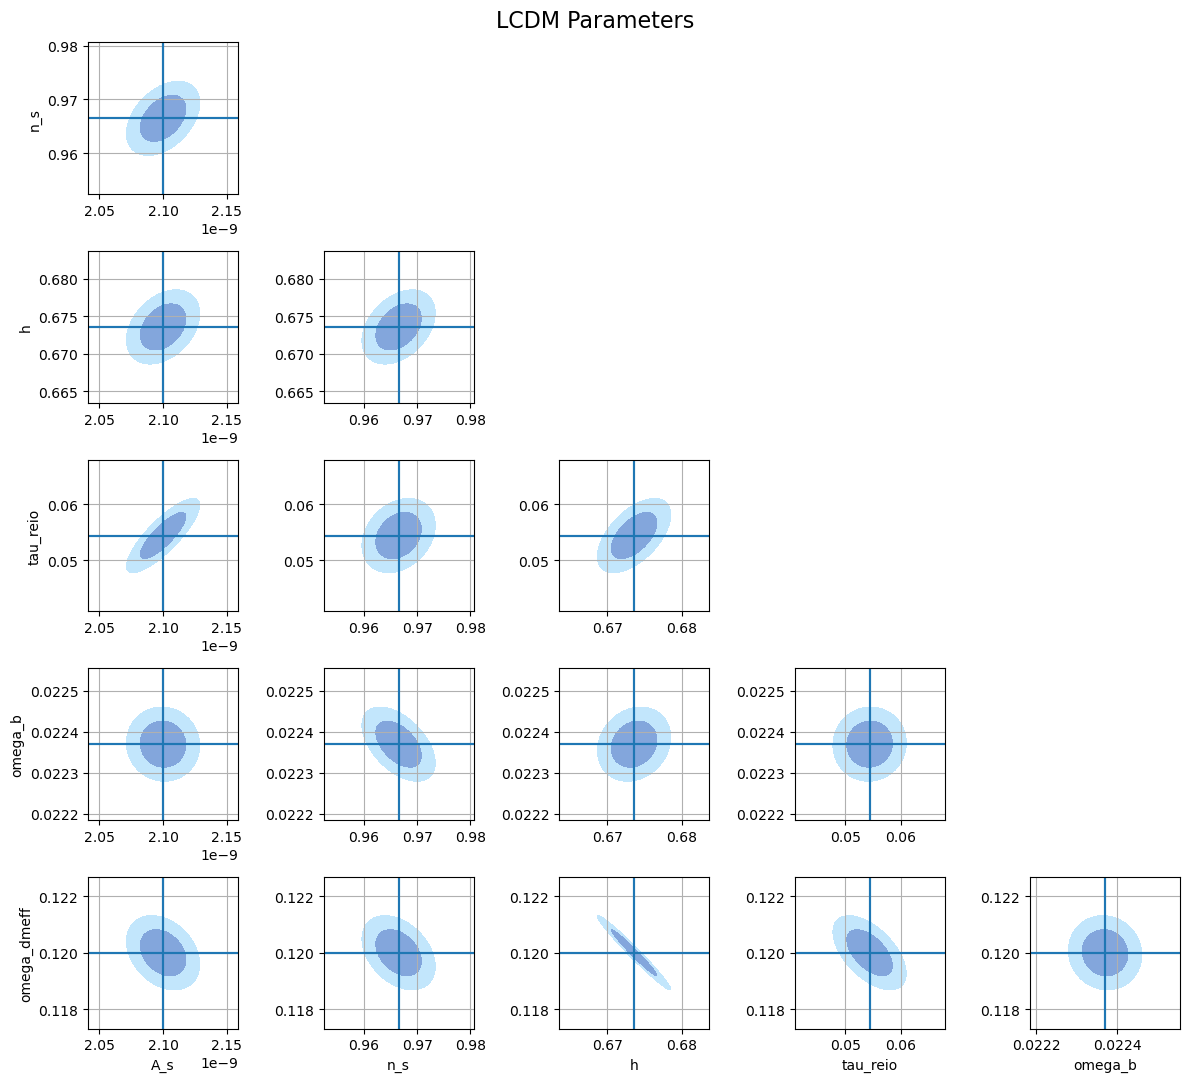

In [186]:
fig, axs = plt.subplots(5, 5, figsize=(12, 11))
fig.suptitle('LCDM Parameters', fontsize=16)

for j, param_1 in enumerate(params_LCDM[:-1]):
    for i, param_2 in enumerate(params_LCDM[1:]):
        if i < j:
            axs[i, j].remove()
        else:
#             axs[i, j].set_title(param_1 + ', ' + param_2)
            for f in [0.434, 0.167]:
                # Compute G
                G = marg2(F_CMB, j, i + 1)
                
                # Distiinguish different confidence levels with colors
                if f == 0.434:
                    color = 'navy'
                else:
                    color = 'lightskyblue'
                
                # Plot the Fisher ellipse
                plot_quadratic_curve(
                    ax=axs[i, j], color=color,
                    x0=params[param_1], y0=params[param_2],
                    sx=5/np.sqrt(marg1(F_CMB, j)), sy=5/np.sqrt(marg1(F_CMB, i + 1)),
                    G=G, f=f)
            
            # Add labels
            if i == 4:
                axs[i, j].set_xlabel(param_1)
            if j == 0:
                axs[i, j].set_ylabel(param_2)

fig.tight_layout()

Plot the $D_l$ of several observables in both SDM and LCDM Universes. The difference is hard to see for cross sections smaller than $10^-{40} \ \text{cm}^2$, which is the case for our fiducial value. However Fisher analysis can still be performed.

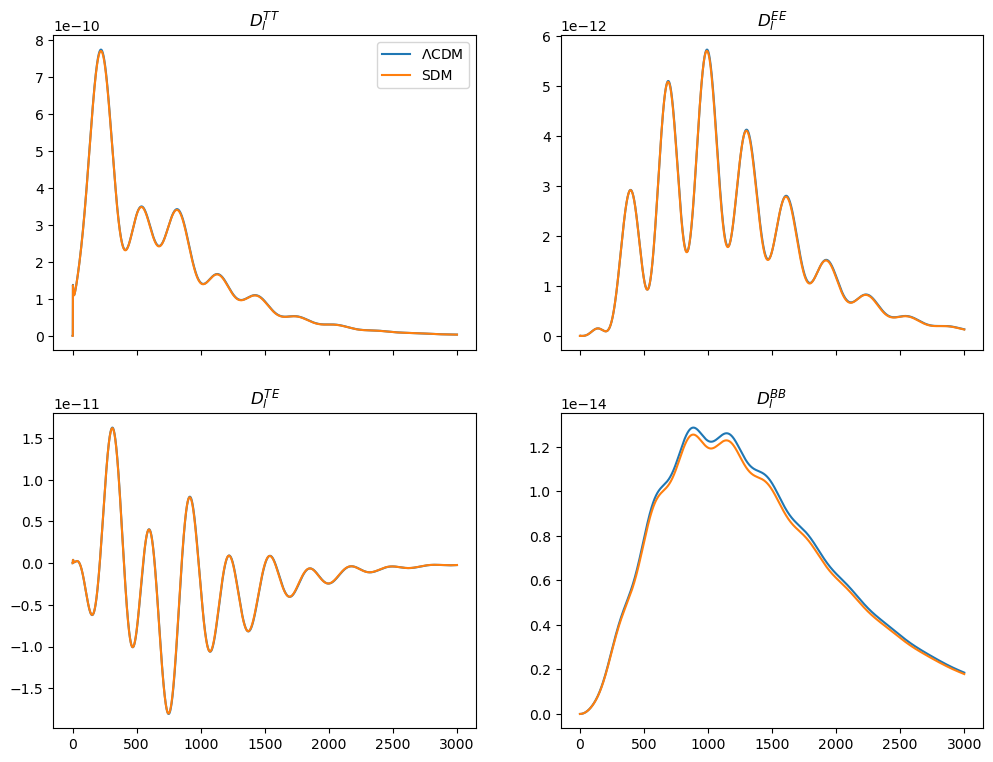

In [180]:
Cl_lensed = cosmo.lensed_cl(3000)
ell = Cl_lensed['ell']

fig, axs = plt.subplots(2, 2, figsize=(12, 9), sharex=True)

axs[0, 0].plot(ell, ell*(ell + 1)/(2*np.pi)*np.load('Cl_lensed_TT_LCDM.npy'), label=r'$\Lambda$CDM')
axs[0, 0].legend()
axs[0, 0].set_title(r'$D_l^{TT}$')
axs[0, 1].plot(ell, ell*(ell + 1)/(2*np.pi)*np.load('Cl_lensed_EE_LCDM.npy'))
axs[0, 1].set_title(r'$D_l^{EE}$')
axs[1, 0].plot(ell, ell*(ell + 1)/(2*np.pi)*np.load('Cl_lensed_TE_LCDM.npy'))
axs[1, 0].set_title(r'$D_l^{TE}$')
axs[1, 1].plot(ell, ell*(ell + 1)/(2*np.pi)*np.load('Cl_lensed_BB_LCDM.npy'))
axs[1, 1].set_title(r'$D_l^{BB}$')

axs[0, 0].plot(ell, ell*(ell + 1)/(2*np.pi)*Cl_lensed['tt'], label='SDM')
axs[0, 0].legend()
axs[0, 0].set_title(r'$D_l^{TT}$')
axs[0, 1].plot(ell, ell*(ell + 1)/(2*np.pi)*Cl_lensed['ee'])
axs[0, 1].set_title(r'$D_l^{EE}$')
axs[1, 0].plot(ell, ell*(ell + 1)/(2*np.pi)*Cl_lensed['te'])
axs[1, 0].set_title(r'$D_l^{TE}$')
axs[1, 1].plot(ell, ell*(ell + 1)/(2*np.pi)*Cl_lensed['bb'])
axs[1, 1].set_title(r'$D_l^{BB}$')

plt.plot();

---

## `21cmFirstCLASS` for 21-cm Power Spectrum Data

In [2]:
# These code are based on the demo file given in the source code of 21cmFirstCLASS

import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt

def run_21cmFast(user_params,
                 astro_params,
                 flag_options,
                 cosmo_params,
                 save_coeval_types=None,
                 save_coeval_redshift_range=None,
                 get_c_T=None,
                 seed=7):
    lightcone_quantities = ('brightness_temp',) # Tk_box, xH_box, density
    global_quantities = ('brightness_temp', 'Tk_box', 'Ts_box', 'xH_box',
                         'T_chi_box', 'V_chi_b_box', 'x_e_box')
    #global_params.FILTER = 0
    #global_params.REDSHIFT_2LPT = 299.
    #global_params.EVOLVE_DENSITY_LINEARLY = 1
    #global_params.T_USE_VELOCITIES = 0
    lightcone = p21c.run_lightcone(redshift = 6.,
                                   random_seed = seed,
                                   regenerate = True,
                                   write = False,
                                   lightcone_quantities = lightcone_quantities,
                                   global_quantities = global_quantities,
                                   user_params = user_params,
                                   astro_params = astro_params,
                                   flag_options = flag_options,
                                   cosmo_params = cosmo_params,
                                   save_coeval_quantities = save_coeval_types,
                                   save_coeval_redshifts = save_coeval_redshift_range,
                                   get_c_T = get_c_T,
                                   direc='_cache')
    return lightcone

/home/ningy/21cmFirstCLASS/src/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/ningy/21cmFirstCLASS/src/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
# Some tool functions we need to compute the power spectrum

# For a value, find the index of its nearest bin
def find_nearest(bin_array, value):
    idx = (np.abs(bin_array - value)).argmin() # bin centers
    return idx

# Compute the angule-averaged power spectrum
def power_spec(cube, HII_DIM, BOX_LEN, kmin, kmax, npoints):
    # Get rid of the mean
    cube -= np.mean(cube)

    # Box info
    nx, ny, nz = HII_DIM, HII_DIM, HII_DIM
    D_trans_x = BOX_LEN # Mpc
    D_trans_y = BOX_LEN # Mpc
    D_los = BOX_LEN # Mpc
    dV = (D_trans_x/nx)*(D_trans_y/ny)*(D_los/nz)
    
    # k values; Note the 2pi to be consistent with cosmological Fourier convention.
    kprxs = np.fft.fftfreq(nx, D_trans_x/nx/(2*np.pi)) # k = 2pi/D is the reciprocal of the product of the 2 arguments
    kprys = np.fft.fftfreq(ny, D_trans_y/ny/(2*np.pi))
    kpls = np.fft.fftfreq(nz, D_los/nz/(2*np.pi))
    kpls = kpls[:int(nz/2)] # Cube is real-valued, so only half of k-space is independent
    
    kmag = np.logspace(np.log10(kmin), np.log10(kmax), npoints)
    pspec = np.zeros_like(kmag)
    
    # sort k by magnitude
    crds = {}
    for indk in kmag: crds[indk] = {'x': [], 'y': [], 'z': []}
    for q, kprx in enumerate(kprxs):
        for r, kpry in enumerate(kprys):
            for s, kpl in enumerate(kpls):
                k = np.sqrt(kpl**2 + kpry**2 + kprx**2)
                if k > kmax: continue
                indk = find_nearest(kmag, k)
                crds[kmag[indk]]['x'].append(q)
                crds[kmag[indk]]['y'].append(r)
                crds[kmag[indk]]['z'].append(s)
    
    
    
    cube_k = np.fft.fftn(cube)*dV # Pay attention to discrete FFT normalization factors
    Pk = cube_k*np.conj(cube_k)/(D_trans_x*D_trans_y*D_los)
    Pk = Pk.real # No need for imaginary part once multiplied by complex conjugate
    Pk = Pk[:, :, :int(nz/2)] # Half of cube isn't independent
    
    # Do the binning
    for ind, indk in enumerate(kmag):
        pspec[ind] = np.mean(Pk[crds[indk]['x'], crds[indk]['y'], crds[indk]['z']])
    
    return kmag, pspec

Below are the input for our simulation.

In [4]:
# Set inputs for the simulation
# These code are based on the demo file given in the source code of 21cmFirstCLASS

# Set flags for the simulation
PLOT_GLOBAL_SIGNAL = True
PLOT_POWER_SPECTRUM_AT_K = False
PLOT_POWER_SPECTRUM_AT_Z = False
RUN_21CMSENSE = False
RUN_FISHER = False
FISHER_TYPE = '21cm'
SAVE_RESULTS = False

# Set parameters for the simulation
user_params = {"HII_DIM": 25, "BOX_LEN": 100, "N_THREADS": 6,
               "RUN_CLASS": True,
               "FUZZY_DM": False,
               "SCATTERING_DM": True,
               "MANY_Z_SAMPLES_AT_COSMIC_DAWN": True,
               "START_AT_RECOMBINATION": True, "USE_HYREC": True,
               "OUTPUT_AT_DARK_AGES": False,
               "EVOLVE_BARYONS": False,
               "EVALUATE_TAU_REIO": False
}
# Table 1 (EOS2021) of arXiv:2110.13919
astro_params = {"F_STAR10": -1.25,
                "F_STAR7_MINI": -2.5,
                "ALPHA_STAR": 0.5,
                "ALPHA_STAR_MINI": 0.,
                "F_ESC10": -1.35,
                "F_ESC7_MINI": -1.35,
                "ALPHA_ESC": -0.3,
                "L_X": 35., "L_X_MINI": 40.5,
                "NU_X_THRESH": 500.}
flag_options = {"USE_CMB_HEATING": False,
                "USE_Lya_HEATING": False,
                "USE_MINI_HALOS": False,
                "USE_MASS_DEPENDENT_ZETA": True,
                "SUBCELL_RSD": False}
# Planck 2018, Table 2, last column
# cosmo_params = {'hlittle': 0.6766,
#                 'OMb': 0.02242/(0.6766**2),
#                 'OMm': 0.11933/(0.6766**2),
#                 'A_s': 2.105e-9,
#                 'POWER_INDEX': 0.9665,
#                 'tau_reio': 0.0561,
#                 'm_chi': 6., 'f_chi': 0., 'sigma_SDM': 41., 'SDM_INDEX': -4.,
#                 # 'm_FDM': 25., 'f_FDM': 1.
# }
# Planck 2018, Table 2, 2nd to last column
cosmo_params = {'hlittle': 0.6736,
                'OMb': 0.0493,
                'OMm': 0.3153,
                'A_s': 2.1e-9,
                'POWER_INDEX': 0.9649,
                'tau_reio': 0.0544,
                'm_chi': 6., 'f_chi': 0., 'sigma_SDM': 42., 'SDM_INDEX': -4.,
                # 'm_FDM': 25., 'f_FDM': 1.
}

# Set a label for the simulation
if user_params["SCATTERING_DM"]:
    file_label = 'SDM,'
else:
    file_label = 'CDM,'
if user_params["START_AT_RECOMBINATION"]:
    file_label += 'z_i=REC'
else:
    file_label += 'z_i=35'
if user_params["SCATTERING_DM"]:
    file_label += ',m_chi='+str(cosmo_params['m_chi'])
    file_label += ',sigma_SDM='+str(cosmo_params['sigma_SDM'])
    file_label += ',f_chi='+str(cosmo_params['f_chi'])
label = 'label'

In [5]:
# Initialize our data

Pks = {
    'OG': {},
    'm_chi': {},
    'sigma_SDM': {}
}

In [6]:
# Run 21cmFast for multiple times with different seeds

h = 1e-3
for p in Pks.keys():
    # Vary cosmo_params as needed
    cosmo_params_temp = cosmo_params
    if p != 'OG':
        cosmo_params_temp[p] += cosmo_params[p]*h
    
    for seed in range(0, 6):
        print('Seed: ', seed)

        lightcone = run_21cmFast(user_params=user_params,
                                astro_params=astro_params,
                                flag_options=flag_options,
                                cosmo_params=cosmo_params_temp,
                                save_coeval_types=['brightness_temp'],
                                save_coeval_redshift_range=[10., 12., 15., 18., 20.],
                                get_c_T=True,
                                seed=seed
        )

        # Compute the T_21 power spectrum
        Pks[p][seed] = {}
        for z in lightcone.coeval_boxes.keys():
            kmag, Pk = power_spec(
                lightcone.coeval_boxes[z]['brightness_temp'],
                lightcone.user_params.HII_DIM, lightcone.user_params.BOX_LEN,
                kmin=np.pi/lightcone.user_params.BOX_LEN, kmax=2*np.pi/lightcone.cell_size,
                npoints=12
            )
            Pks[p][seed][z] = Pk

Seed:  0
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [03:10<00:00,  1.53redshift/s]
/home/ningy/miniconda3/envs/p21FC_new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ningy/miniconda3/envs/p21FC_new/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Seed:  1
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [03:14<00:00,  1.49redshift/s]


Seed:  2
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:53<00:00,  1.67redshift/s]


Seed:  3
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:41<00:00,  1.80redshift/s]


Seed:  4
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:43<00:00,  1.78redshift/s]


Seed:  5
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:30<00:00,  1.93redshift/s]


Seed:  0
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:40<00:00,  1.81redshift/s]


Seed:  1
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:31<00:00,  1.92redshift/s]


Seed:  2
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:41<00:00,  1.80redshift/s]


Seed:  3
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:31<00:00,  1.92redshift/s]


Seed:  4
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:42<00:00,  1.79redshift/s]


Seed:  5
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:45<00:00,  1.76redshift/s]


Seed:  0
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:45<00:00,  1.76redshift/s]


Seed:  1
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:47<00:00,  1.74redshift/s]


Seed:  2
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:45<00:00,  1.76redshift/s]


Seed:  3
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:44<00:00,  1.77redshift/s]


Seed:  4
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:46<00:00,  1.75redshift/s]


Seed:  5
Now running CLASS...
Now generating initial boxes...
Now going through the dark ages...


21cmFAST (cosmic dawn): 100%|██████████| 291/291 [02:44<00:00,  1.77redshift/s]


In [83]:
# Compute the mean of Delta(k)
Pks_mean = {}

for p in Pks:
    temp1 = [Pks[p][seed] for seed in Pks[p]]
    temp2 = []
    for i, d in enumerate(temp1):
        for z in d:
            temp2.append(d[z])
    temp2 = kmag**3/(2*np.pi**2)*np.array(temp2)
    Pks_mean[p] = np.nanmean(temp2, axis=0)

    if p == 'OG':
    # Compute the variance of Delta(k)
        temp3 = [(arr - Pks_mean[p])**2 for arr in temp2]
        Pks_var = np.nanmean(temp3, axis=0)

/tmp/ipykernel_467317/1846144310.py:11: RuntimeWarning: Mean of empty slice
  Pks_mean[p] = np.nanmean(temp2, axis=0)
/tmp/ipykernel_467317/1846144310.py:16: RuntimeWarning: Mean of empty slice
  Pks_var = np.nanmean(temp3, axis=0)


In [160]:
# Compute the 21-cm Fisher matrix

F_21 = np.zeros((2, 2))
F_temp = np.zeros((2, 2))

for i, k in enumerate(kmag):
    dPdp1 = (Pks_mean['m_chi'][i] - Pks_mean['OG'][i])/(cosmo_params['m_chi']*h)
    dPdp2 = (Pks_mean['sigma_SDM'][i] - Pks_mean['OG'][i])/(cosmo_params['sigma_SDM']*h)
    F_temp[0, 0] = dPdp1*dPdp1
    F_temp[0, 1] = dPdp1*dPdp2
    F_temp[1, 0] = dPdp2*dPdp1
    F_temp[1, 1] = dPdp2*dPdp2
    if not np.isnan(F_temp).any(): # get rid of nan matrices
        F_21 += F_temp/Pks_var[i]

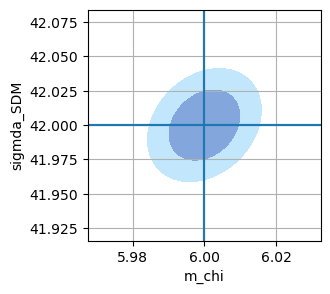

In [172]:
# Plot the Fisher ellipse for the 2 SDM parameters

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_xlabel('m_chi')
ax.set_ylabel('sigmda_SDM')

for f in [0.434, 0.167]:
    # Distinguish different confidence levels with colors
    if f == 0.434:
        color = 'navy'
    else:
        color = 'lightskyblue'

    # Plot the Fisher ellipse
    plot_quadratic_curve(
        ax=ax, color=color,
        x0=cosmo_params['m_chi'], y0=cosmo_params['sigma_SDM'],
        sx=5/np.sqrt(marg1(F_21, 0)), sy=5/np.sqrt(marg1(F_21, 1)),
        G=F_21, f=f
    )

## Misc. Plots

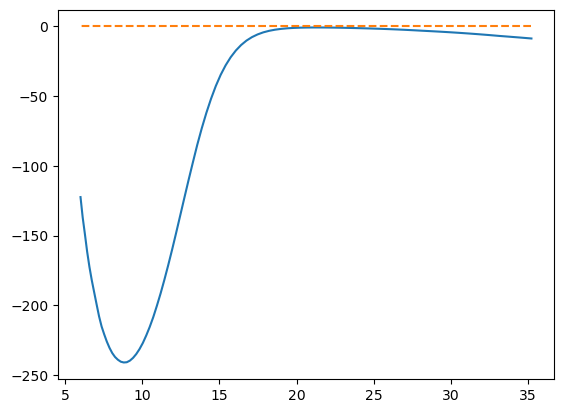

In [67]:
# Plot the global T_21

plt.plot(output['z_global'], output['T_21_global'], label=label)
plt.plot([output['z_global'][0], output['z_global'][-1]], [0, 0], '--')
plt.show();

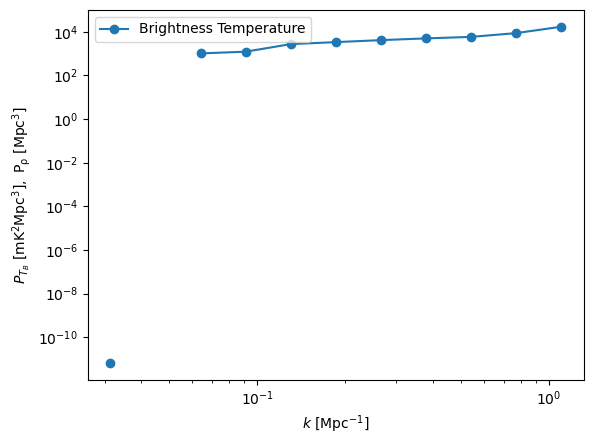

In [53]:
# Plot the T_21 power spectrum
plt.loglog(kmag, kmag**3/(2*np.pi**2)*Pks_mean['OG'], label='Brightness Temperature', marker='o')
plt.ylabel(r'$P_{T_B} \ [\rm{mK}^2 \rm{Mpc}^3 ],\ P_\rho \ [\rm{Mpc}^3 ]$')
plt.xlabel(r'$k\ [\rm{Mpc}^{-1}]$')
plt.legend()
plt.show();